In [61]:
# Import required libraries
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [63]:
# Load preprocessed data
with open('processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
scalers = data['scalers']
feature_columns = data['feature_columns']

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (1320, 60, 10)
Testing shape: (331, 60, 10)


In [65]:
# Increased capacity model
model = Sequential([
    # First CNN block with more filters
    Conv1D(128, 5, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.1),
    
    # Second CNN block with more filters
    Conv1D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),  # Increased neurons
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation='relu'),   # Added another dense layer
    BatchNormalization(),
    Dense(1)
])

# Slightly lower learning rate for stability with larger network
model.compile(optimizer=Adam(learning_rate=0.0003),
             loss='mse',
             metrics=['mae'])

model.summary()

C:\Users\dogwa\anaconda3\envs\Python_AI\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)                   │ (None, 60, 128)             │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 60, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 60, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 60, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         491,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 532,673 (2.03 MB)

 Trainable params: 531,905 (2.03 MB)

 Non-trainable params: 768 (3.00 KB)

In [67]:
# Modified callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', 
                  patience=20,              # Increased patience
                  restore_best_weights=True,
                  min_delta=0.00001),
    ReduceLROnPlateau(monitor='val_loss', 
                      factor=0.3,           # More gradual reduction
                      patience=7,
                      min_lr=0.00001,
                      min_delta=0.00001)
]

# Train with adjusted batch size
history = model.fit(X_train, y_train,
                   batch_size=48,           # Adjusted batch size
                   epochs=150,              # More epochs
                   validation_split=0.2,
                   callbacks=callbacks,
                   verbose=1)

Epoch 1/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.4837 - mae: 0.9399 - val_loss: 0.6578 - val_mae: 0.8080 - learning_rate: 3.0000e-04
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4031 - mae: 0.4841 - val_loss: 0.6717 - val_mae: 0.8165 - learning_rate: 3.0000e-04
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2202 - mae: 0.3620 - val_loss: 0.6127 - val_mae: 0.7796 - learning_rate: 3.0000e-04
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1607 - mae: 0.3153 - val_loss: 0.6153 - val_mae: 0.7808 - learning_rate: 3.0000e-04
Epoch 5/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1255 - mae: 0.2770 - val_loss: 0.5183 - val_mae: 0.7160 - learning_rate: 3.0000e-04
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1204 - mae: 0.2685 - val_loss: 0.5159 - val_mae: 0.7143 - learning_rate: 3.0000e-04
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1058 - mae: 0.2544 - val_loss: 0.4979 - val_mae: 0.7008 - learning_r

In [69]:
# Evaluate model
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_test_orig = scalers[1].inverse_transform(y_test)
y_pred_orig = scalers[1].inverse_transform(y_pred)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

print("\nModel Performance Metrics:")
print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"R-squared Score (R²): {r2:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Model Performance Metrics:
Root Mean Square Error (RMSE): $8.55
Mean Absolute Error (MAE): $6.82
R-squared Score (R²): 0.8098


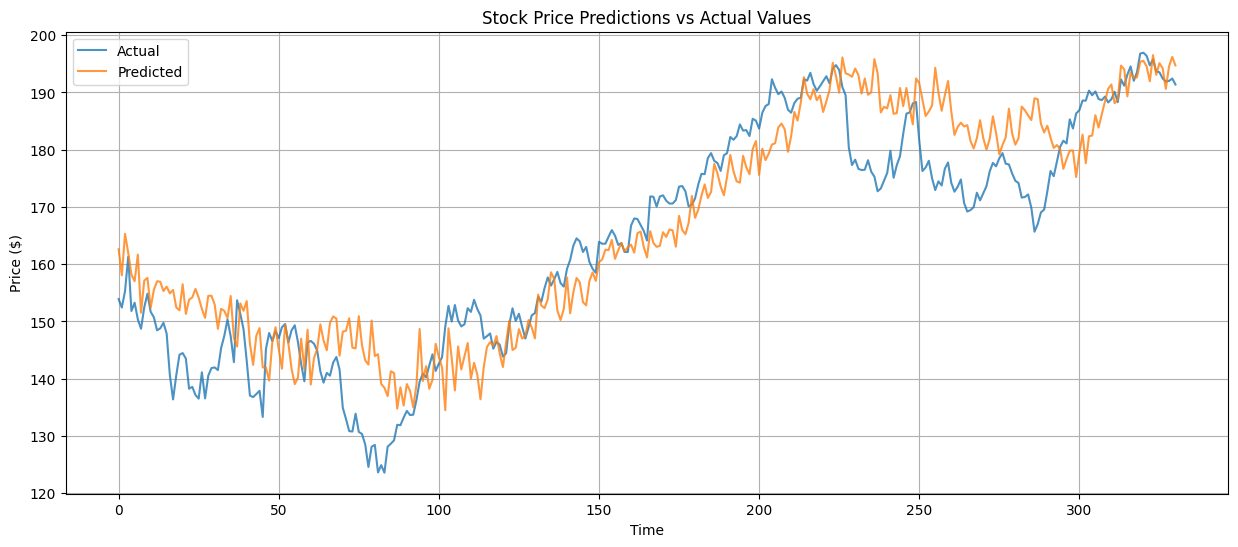

In [72]:
# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test_orig, label='Actual', alpha=0.8)
plt.plot(y_pred_orig, label='Predicted', alpha=0.8)
plt.title('Stock Price Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()